In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, boxcox
from scipy import stats
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import pickle as pk

In [2]:
data = pd.read_csv("used_device_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

In [4]:
data.head()

device_brand       os  screen_size   4g   5g  rear_camera_mp  \
0        Honor  Android        14.50  yes   no            13.0   
1        Honor  Android        17.30  yes  yes            13.0   
2        Honor  Android        16.69  yes  yes            13.0   
3        Honor  Android        25.50  yes  yes            13.0   
4        Honor  Android        15.32  yes   no            13.0   

   front_camera_mp  internal_memory  ram  battery  weight  release_year  \
0              5.0             64.0  3.0   3020.0   146.0          2020   
1             16.0            128.0  8.0   4300.0   213.0          2020   
2              8.0            128.0  8.0   4200.0   213.0          2020   
3              8.0             64.0  6.0   7250.0   480.0          2020   
4              8.0             64.0  3.0   5000.0   185.0          2020   

   days_used  normalized_used_price  normalized_new_price  
0        127               4.307572              4.715100  
1        325               5.162097              5.519018  
2        162               5.111084              5.884631  
3        345               5.135387              5.630961  
4        293               4.389995              4.947837

In [5]:
data.describe()

screen_size  rear_camera_mp  front_camera_mp  internal_memory  \
count  3454.000000     3275.000000      3452.000000      3450.000000   
mean     13.713115        9.460208         6.554229        54.573099   
std       3.805280        4.815461         6.970372        84.972371   
min       5.080000        0.080000         0.000000         0.010000   
25%      12.700000        5.000000         2.000000        16.000000   
50%      12.830000        8.000000         5.000000        32.000000   
75%      15.340000       13.000000         8.000000        64.000000   
max      30.710000       48.000000        32.000000      1024.000000   

               ram      battery       weight  release_year    days_used  \
count  3450.000000  3448.000000  3447.000000   3454.000000  3454.000000   
mean      4.036122  3133.402697   182.751871   2015.965258   674.869716   
std       1.365105  1299.682844    88.413228      2.298455   248.580166   
min       0.020000   500.000000    69.000000   2013.000000    91.000000   
25%       4.000000  2100.000000   142.000000   2014.000000   533.500000   
50%       4.000000  3000.000000   160.000000   2015.500000   690.500000   
75%       4.000000  4000.000000   185.000000   2018.000000   868.750000   
max      12.000000  9720.000000   855.000000   2020.000000  1094.000000   

       normalized_used_price  normalized_new_price  
count            3454.000000           3454.000000  
mean                4.364712              5.233107  
std                 0.588914              0.683637  
min                 1.536867              2.901422  
25%                 4.033931              4.790342  
50%                 4.405133              5.245892  
75%                 4.755700              5.673718  
max                 6.619433              7.847841

In [6]:
categorical_data=pd.DataFrame(data[['device_brand', 'os','4g', '5g','rear_camera_mp','front_camera_mp','internal_memory','ram','battery','release_year','normalized_used_price','normalized_new_price']])

In [7]:
categorical_data.head()

device_brand       os   4g   5g  rear_camera_mp  front_camera_mp  \
0        Honor  Android  yes   no            13.0              5.0   
1        Honor  Android  yes  yes            13.0             16.0   
2        Honor  Android  yes  yes            13.0              8.0   
3        Honor  Android  yes  yes            13.0              8.0   
4        Honor  Android  yes   no            13.0              8.0   

   internal_memory  ram  battery  release_year  normalized_used_price  \
0             64.0  3.0   3020.0          2020               4.307572   
1            128.0  8.0   4300.0          2020               5.162097   
2            128.0  8.0   4200.0          2020               5.111084   
3             64.0  6.0   7250.0          2020               5.135387   
4             64.0  3.0   5000.0          2020               4.389995   

   normalized_new_price  
0              4.715100  
1              5.519018  
2              5.884631  
3              5.630961  
4              4.947837

### Finding the percentage of missing data
Here we inspect the data and clean it. Firstly, we inspect and see how much data is present, before we can decide how to clean it

In [8]:
# Finding percentage of missing values in the data
# Since the number of data that is not found is a small proportion of the total data, removing them will not significantly
# affect the accuracy of the model.
missingValues = data.isnull().sum()

rearCameraMissing = data['rear_camera_mp'].isnull().sum()
frontCameraMissing = data['front_camera_mp'].isnull().sum()
internalMemMissing = data['internal_memory'].isnull().sum()
ramMissing = data['ram'].isnull().sum()
battMissing = data['battery'].isnull().sum()
weightMissing = data['weight'].isnull().sum()

rearCamMissPercent = (rearCameraMissing/len(data['rear_camera_mp']))*100
frontCamMissPercent = (frontCameraMissing/len(data['front_camera_mp']))*100
internalMemMissPercent = (internalMemMissing/len(data['internal_memory']))*100
ramMissPercent = (ramMissing/len(data['ram']))*100
battMissPercent = (battMissing/len(data['battery']))*100
weightMissPercent = (weightMissing/len(data['weight']))*100

print("Percentage of rear camera missing: ", rearCamMissPercent, "%")
print("Percentage of front camera missing: ", frontCamMissPercent, "%")
print("Percentage of internal memory missing: ", internalMemMissPercent, "%")
print("Percentage of ram missing: ", ramMissPercent, "%")
print("Percentage of battery missing: ", battMissPercent, "%")
print("Percentage of weight missing: ", weightMissPercent, "%")

Percentage of rear camera missing:  5.182397220613781 %
Percentage of front camera missing:  0.05790387955993051 %
Percentage of internal memory missing:  0.11580775911986102 %
Percentage of ram missing:  0.11580775911986102 %
Percentage of battery missing:  0.17371163867979156 %
Percentage of weight missing:  0.2026635784597568 %


### Values Distribution
We observe the histogram to determine if there are many outliers and whether the values are normally distributed.

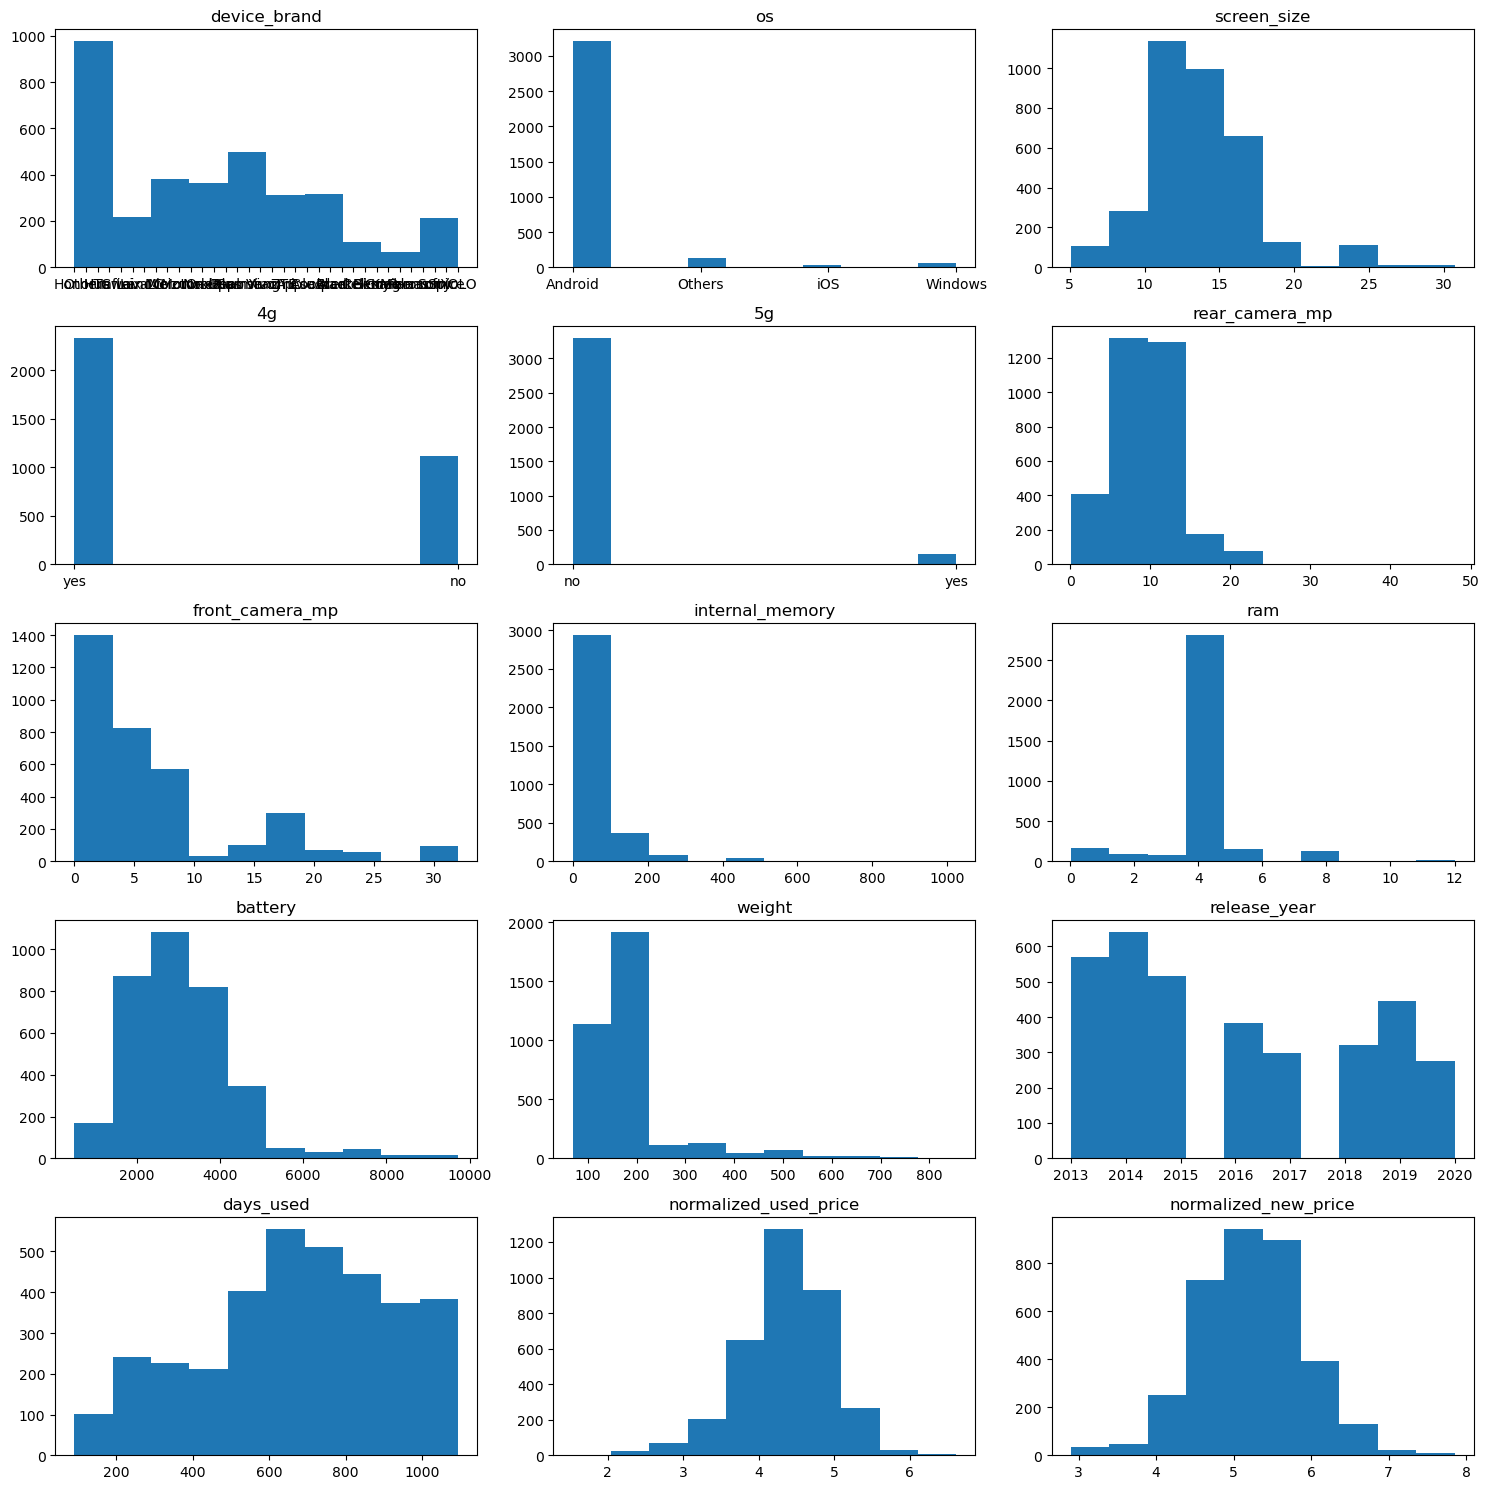

In [9]:
fig,axs= plt.subplots(5,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(data.columns):
    # Plot a histogram of the feature in the current subplot
    axs[i].hist(data[feature])
    axs[i].set_title(feature)


# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()


### What to do with missing data
First we need to look at the skew of the data. If the data is not normal and is skewed, replacing the NULL values with mean or median will result in a high chance that is not accurate.Looking at the histograms, we can identify that the data is not normal, hence, we cannot use mean or median as it would not provide an accurate representation of the data.  As the number of outliers were relatively small and the fact that it would not be accurate if we used mean or median, we chose to drop the data.Therefore, we choose to drop the NULL data.

<AxesSubplot:>

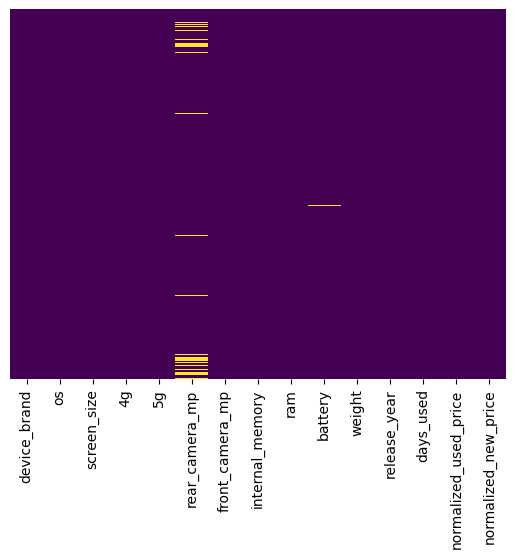

In [10]:
# Visualizing the dataset with missing data
sb.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

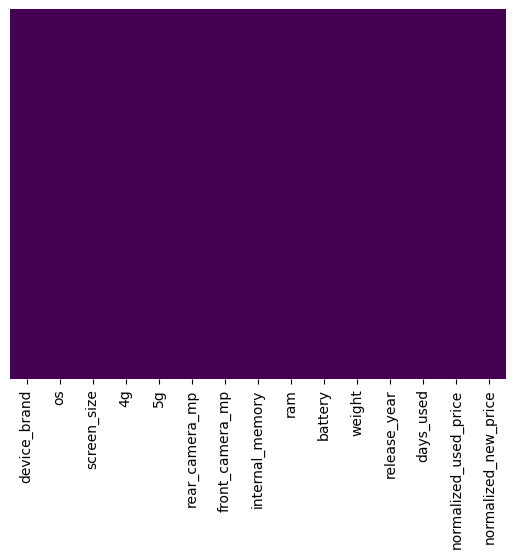

In [11]:
# Visualizing the dataset after removing the missing data
data = data.dropna()
sb.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

### Checking for duplicate data
To make sure there isnt contamination of the training data with the test data or vice versa. 

In [12]:
# Checking for duplicate values
data.duplicated().sum()

0

In [13]:
data

device_brand       os  screen_size   4g   5g  rear_camera_mp  \
0           Honor  Android        14.50  yes   no            13.0   
1           Honor  Android        17.30  yes  yes            13.0   
2           Honor  Android        16.69  yes  yes            13.0   
3           Honor  Android        25.50  yes  yes            13.0   
4           Honor  Android        15.32  yes   no            13.0   
...           ...      ...          ...  ...  ...             ...   
3447        Apple      iOS        15.27  yes   no             8.0   
3450         Asus  Android        15.24  yes   no            13.0   
3451      Alcatel  Android        15.80  yes   no            13.0   
3452      Alcatel  Android        15.80  yes   no            13.0   
3453      Alcatel  Android        12.83  yes   no            13.0   

      front_camera_mp  internal_memory  ram  battery  weight  release_year  \
0                 5.0             64.0  3.0   3020.0   146.0          2020   
1                16.0            128.0  8.0   4300.0   213.0          2020   
2                 8.0            128.0  8.0   4200.0   213.0          2020   
3                 8.0             64.0  6.0   7250.0   480.0          2020   
4                 8.0             64.0  3.0   5000.0   185.0          2020   
...               ...              ...  ...      ...     ...           ...   
3447              7.0             64.0  4.0   3110.0   194.0          2019   
3450              8.0            128.0  8.0   4000.0   200.0          2018   
3451              5.0             32.0  3.0   4000.0   165.0          2020   
3452              5.0             32.0  2.0   4000.0   160.0          2020   
3453              5.0             16.0  2.0   4000.0   168.0          2020   

      days_used  normalized_used_price  normalized_new_price  
0           127               4.307572              4.715100  
1           325               5.162097              5.519018  
2           162               5.111084              5.884631  
3           345               5.135387              5.630961  
4           293               4.389995              4.947837  
...         ...                    ...                   ...  
3447        208               5.100902              6.287933  
3450        541               5.037732              6.251538  
3451        201               4.357350              4.528829  
3452        149               4.349762              4.624188  
3453        176               4.132122              4.279994  

[3253 rows x 15 columns]

# Performing EDA on the data

# Univariate data analysis

In [14]:
# Classifying non-objects as numerical data and objects as categorical data
num_features=[feature for feature in data.columns if data[feature].dtype != 'O']
num_features

['screen_size',
 'rear_camera_mp',
 'front_camera_mp',
 'internal_memory',
 'ram',
 'battery',
 'weight',
 'release_year',
 'days_used',
 'normalized_used_price',
 'normalized_new_price']

In [15]:
cat_features=[feature for feature in data.columns if data[feature].dtype == 'O']
cat_features

['device_brand', 'os', '4g', '5g']

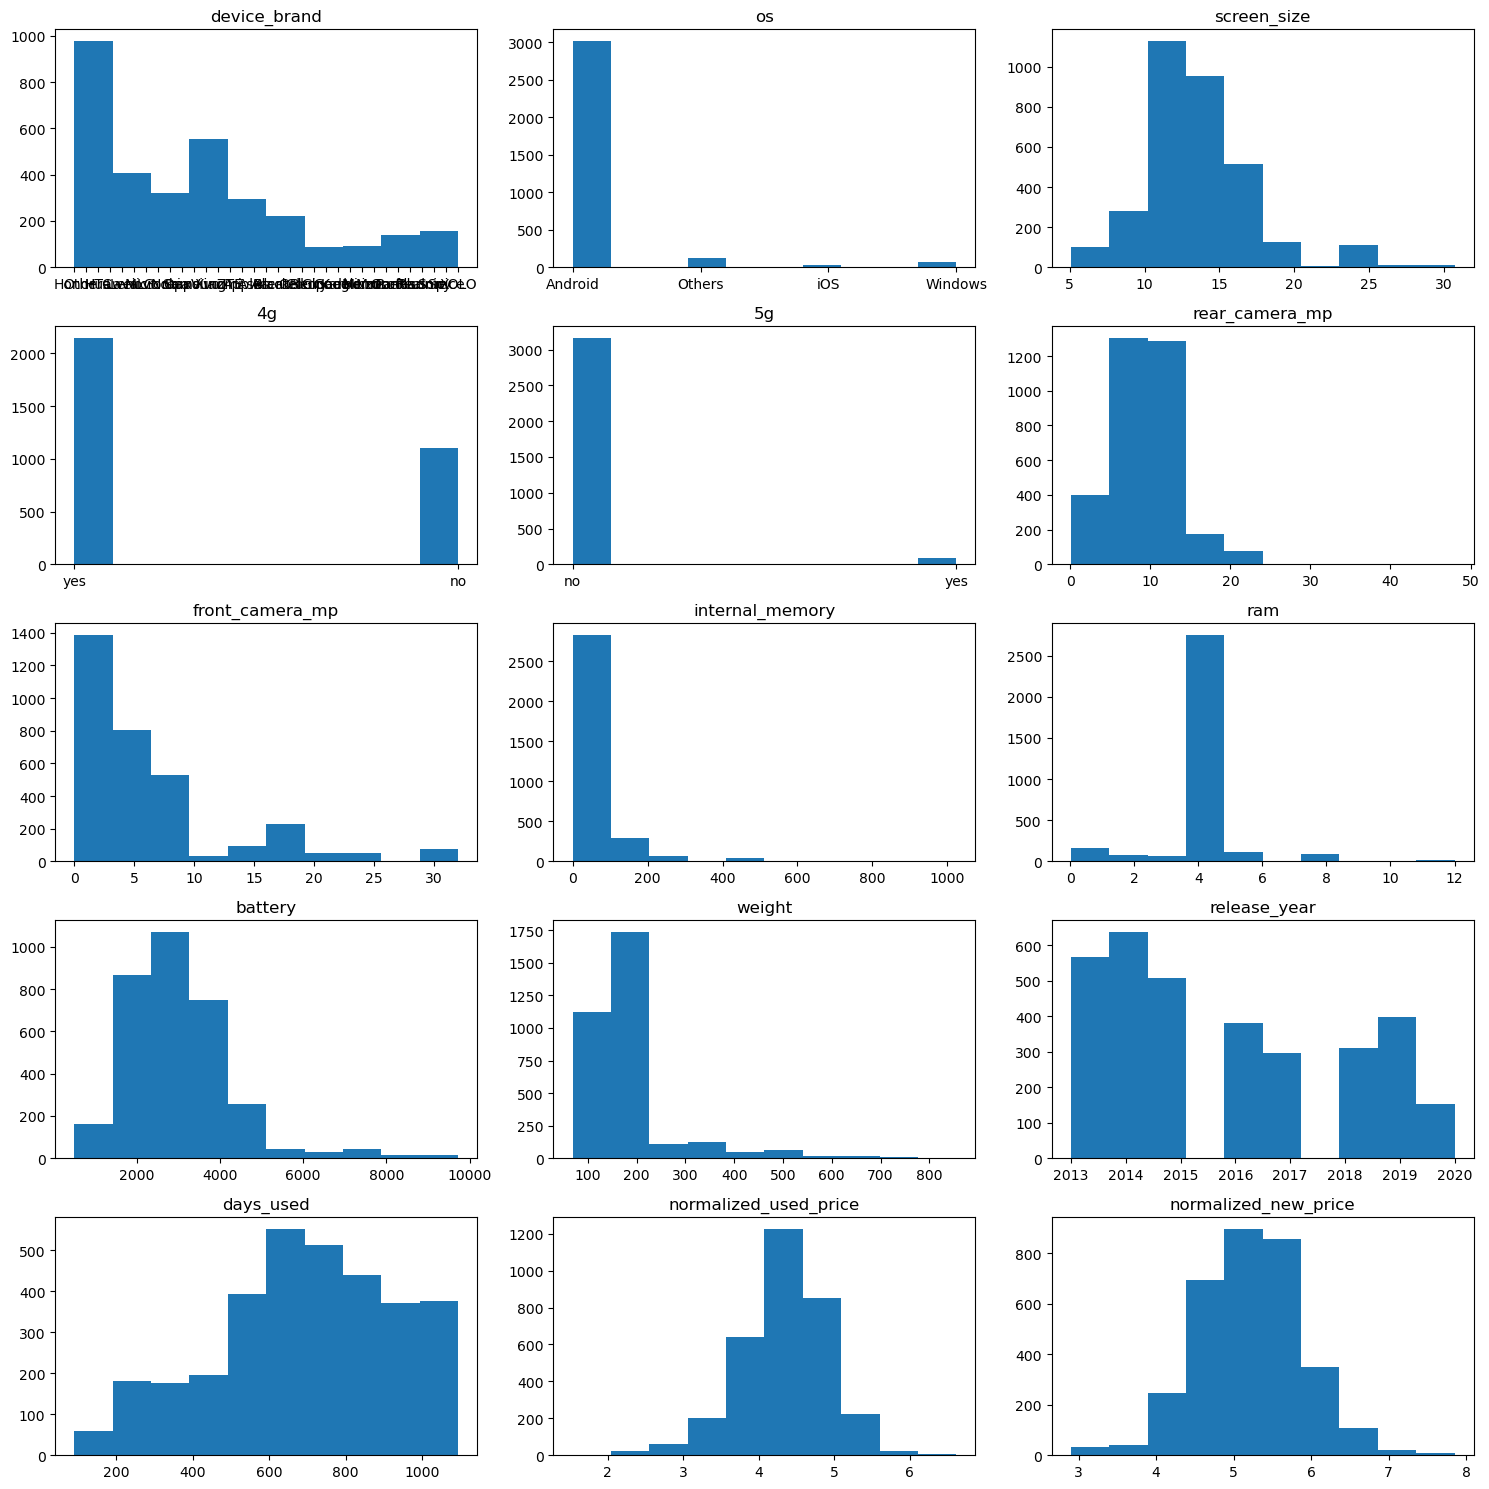

In [16]:
fig,axs= plt.subplots(5,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(data.columns):
    # Plot a histogram of the feature in the current subplot
    axs[i].hist(data[feature])
    axs[i].set_title(feature)


# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()


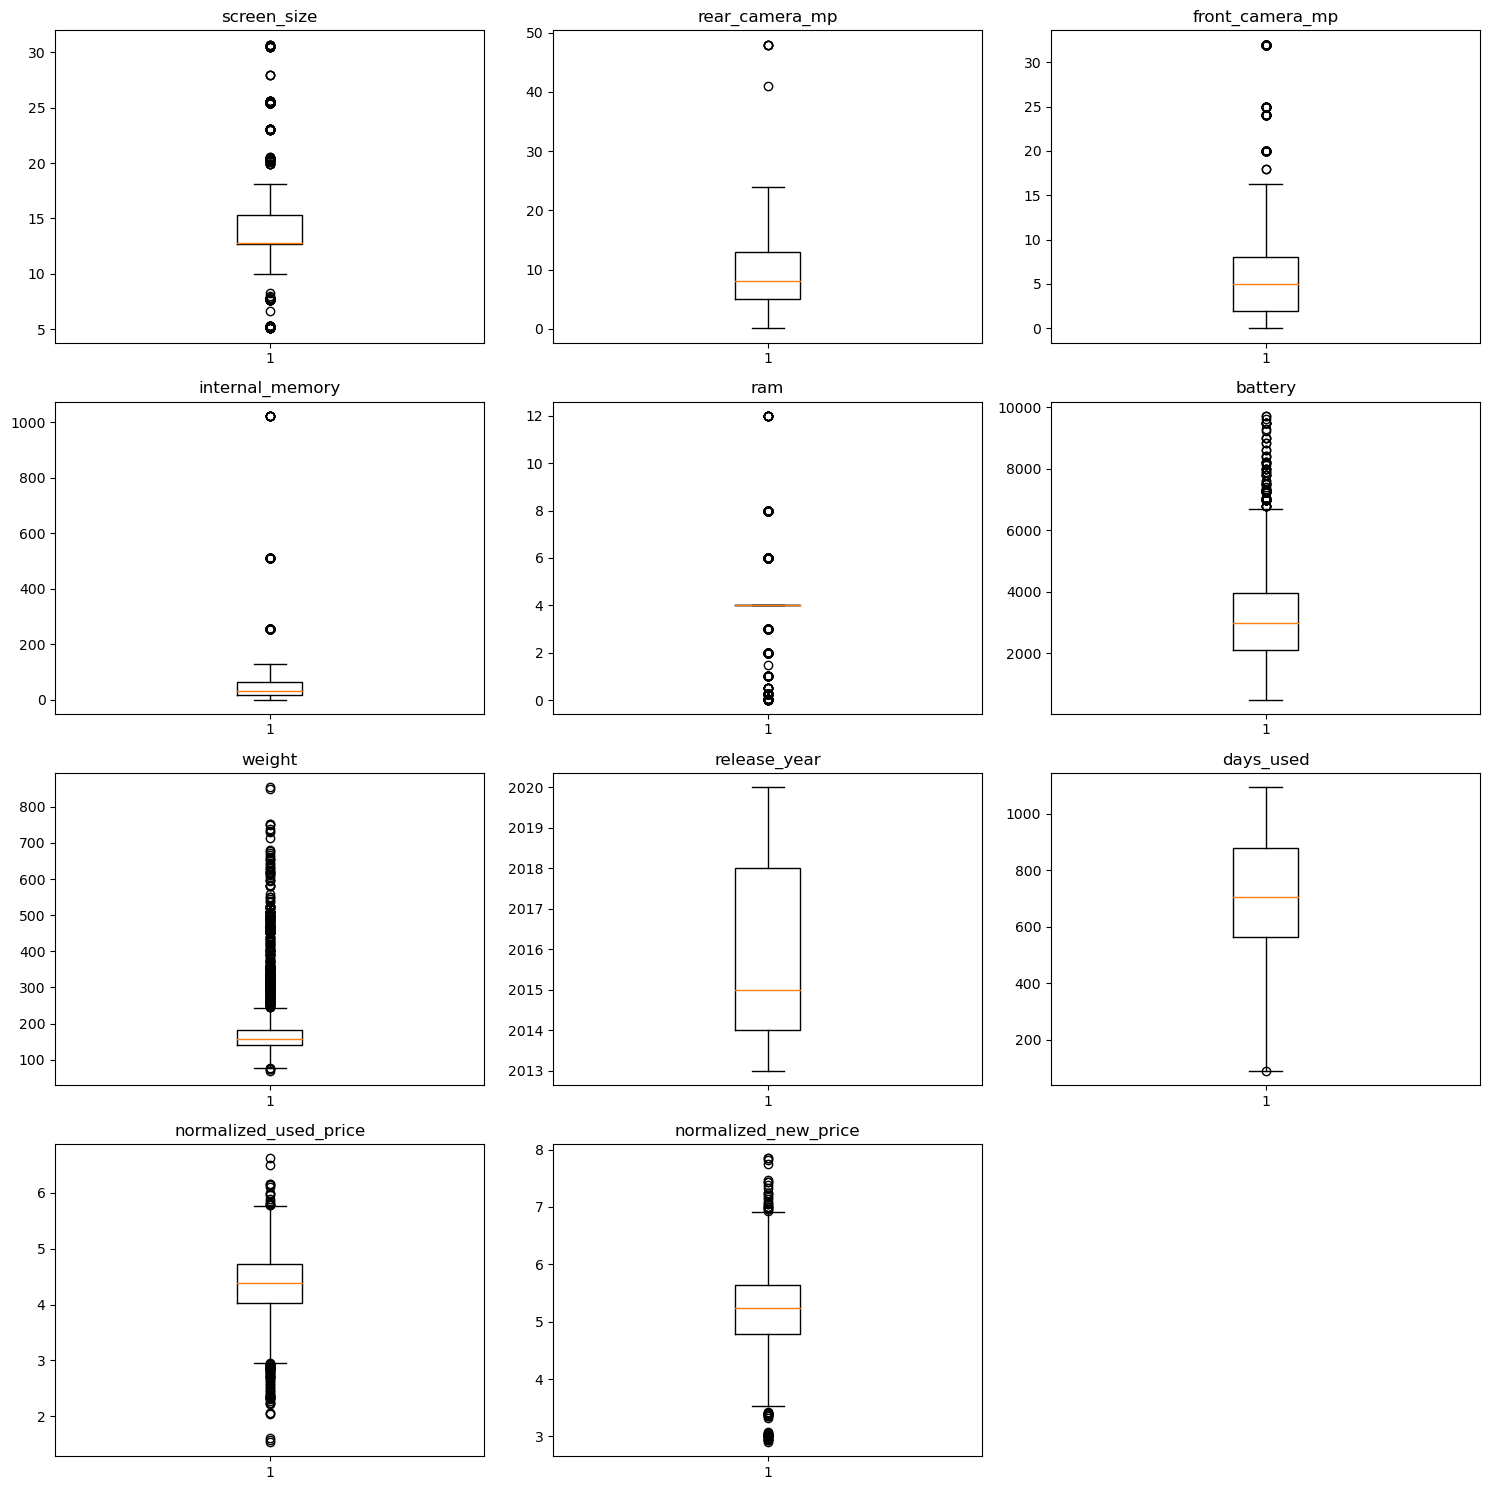

In [17]:
fig,axs= plt.subplots(4,3,figsize=(15, 15))
# Flatten the 2D array of subplots to make them easier to access
axs = axs.ravel()
for i, feature in enumerate(num_features):
    
    axs[i].boxplot(data[feature])
    axs[i].set_title(feature)

# method used to remove an axis from a figure; here removing last grid--> 12th grid since we only have 11 numerical features
fig.delaxes(axs[-1])
# Adjust the spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

### From here we can see that a majority of the data points for RAM are clustered together at 4GB of RAM. However, it is a distribution of the data. In reality, this distribution of RAM can be due to consumer concerns, such as budget constraints or other factors. In general, there is no reasonable justification for us to remove such data, as they represent concerns we are unable to consider, and thus unable to evaluate if it is suitable to be removed or not. 

# Bi-variate data analysis

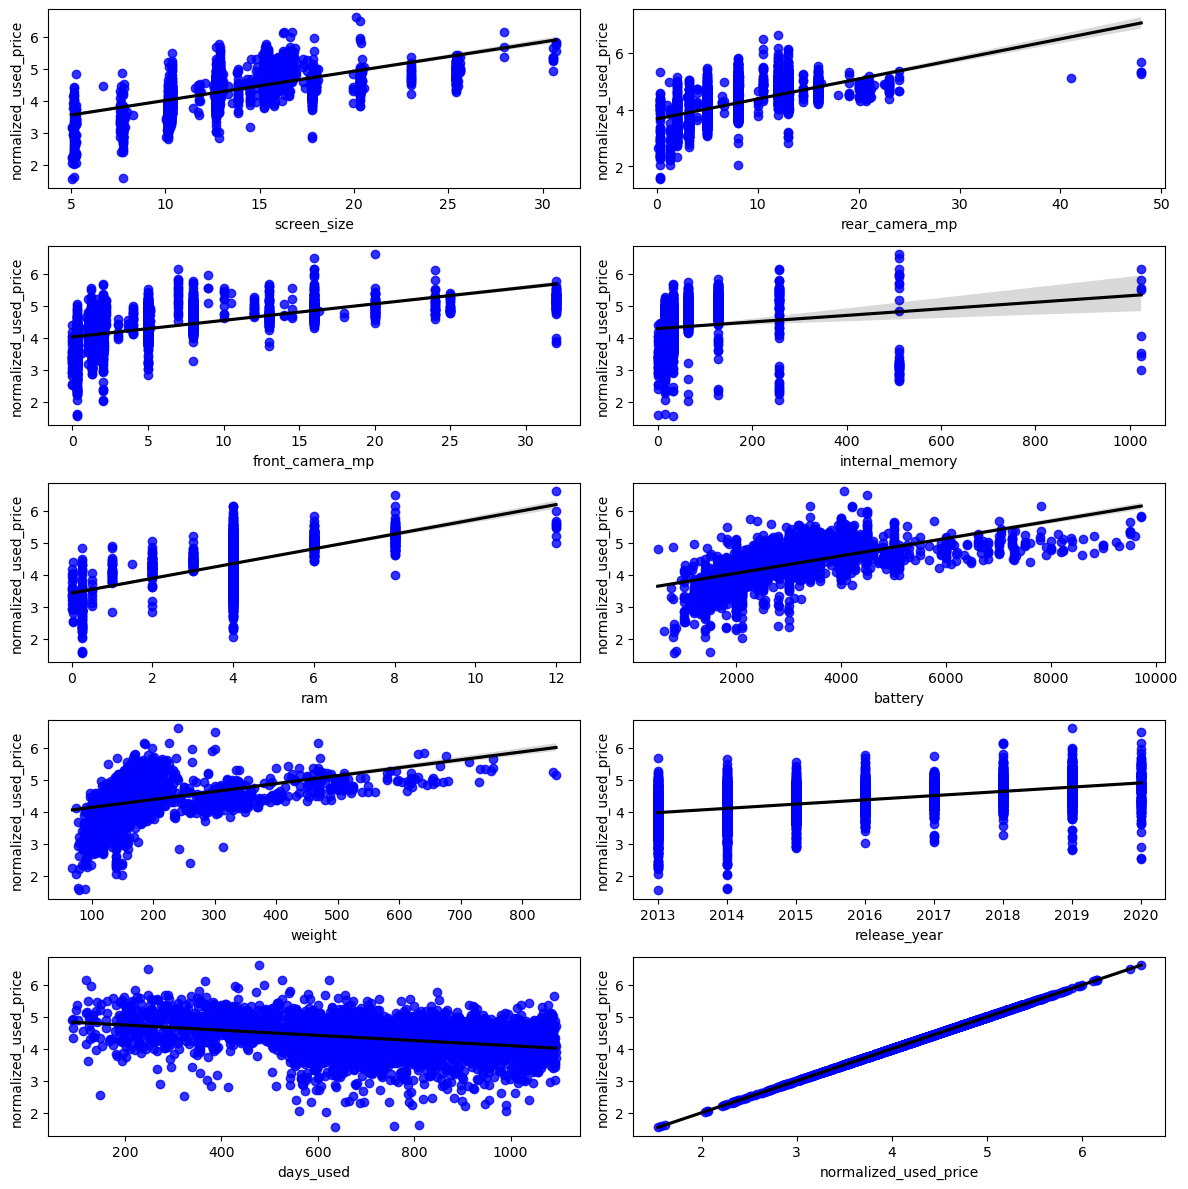

In [20]:
fig,axs= plt.subplots(5,2,figsize=(12,12))
axs=axs.ravel()
for i,ax in enumerate(axs):

    sb.regplot(x=num_features[i],y='normalized_used_price',data=data,ax=ax,color='black',scatter_kws={"color":"blue"})

plt.tight_layout()
plt.show()

### Upon further analysis in our bivariate data analysis, we discovered that there was indeed a relationship between the RAM and price of used devices. Thus, we decided to keep the variable. 

### A possible explanation for this would be manufacturing considerations such as cost, knowledge from market research among many other factors. We also decided to keep this data, as it was representative of the data.

### The linear relationships from this bivariate data analysis reassured us that the variables are related to the dependent variable, used price, which we are planning to predict. This will allow us to proceed with our regression analysis later.

<AxesSubplot:xlabel='4g', ylabel='normalized_used_price'>

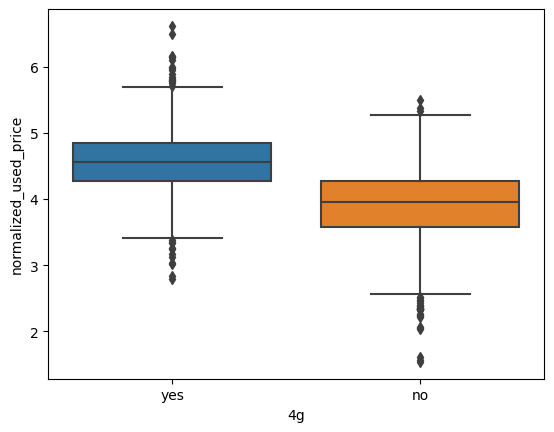

In [21]:
# Plotting the categorical data against normalised used price
sb.boxplot(data=data, x='4g', y=data['normalized_used_price'])

<AxesSubplot:xlabel='5g', ylabel='normalized_used_price'>

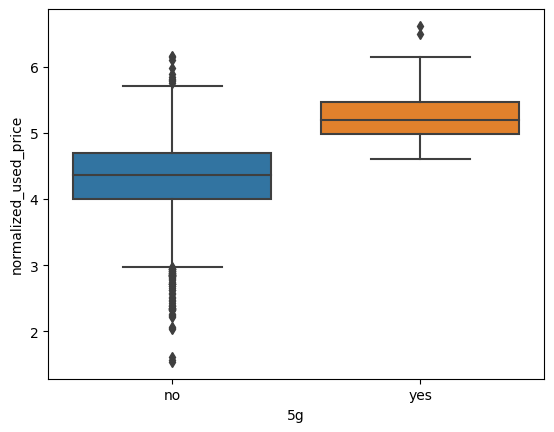

In [22]:
sb.boxplot(data=data, x='5g', y=data['normalized_used_price'])

### As seen above there is a clear difference between the boxplots of the 5g vs no 5g or 4g vs no 4g. This implies that 4g and 5g data can be used as predictors for predicting the trend of used phone price, and should be kept.

## Plotting Pairplot to investigate non-linear relationships, as well as possible clustering of data


In [23]:
 pairplotData = data.drop(columns=['4g', '5g'])
# sb.pairplot(data=pairplotData, hue='device_brand')

### As seen in the hue of the pairplots, the screen size could be used as a predictor in predicting the normalized used price, since the data seems to be segregated into clusters of similar screen size and similar normalized used price. Perhaps we can use it to determine if the phones are "expensive". Though that requires some more definitions

### Weight and battery can be seen to exhibit a linear relationships with each other. This factor is one of what justifies the use of Ridge Regression.

### Release year and days used can also be seen to exhibit a seemingly linear relationship. 

### However, it is heartening to see that all the variables present can be used to predict the used device prices, indicating that we can indeed fit models to predict used device prices. Though the distributions might not be linear, there are relationships, which we can model. Different regression models could be used to account for these non-linear relationships

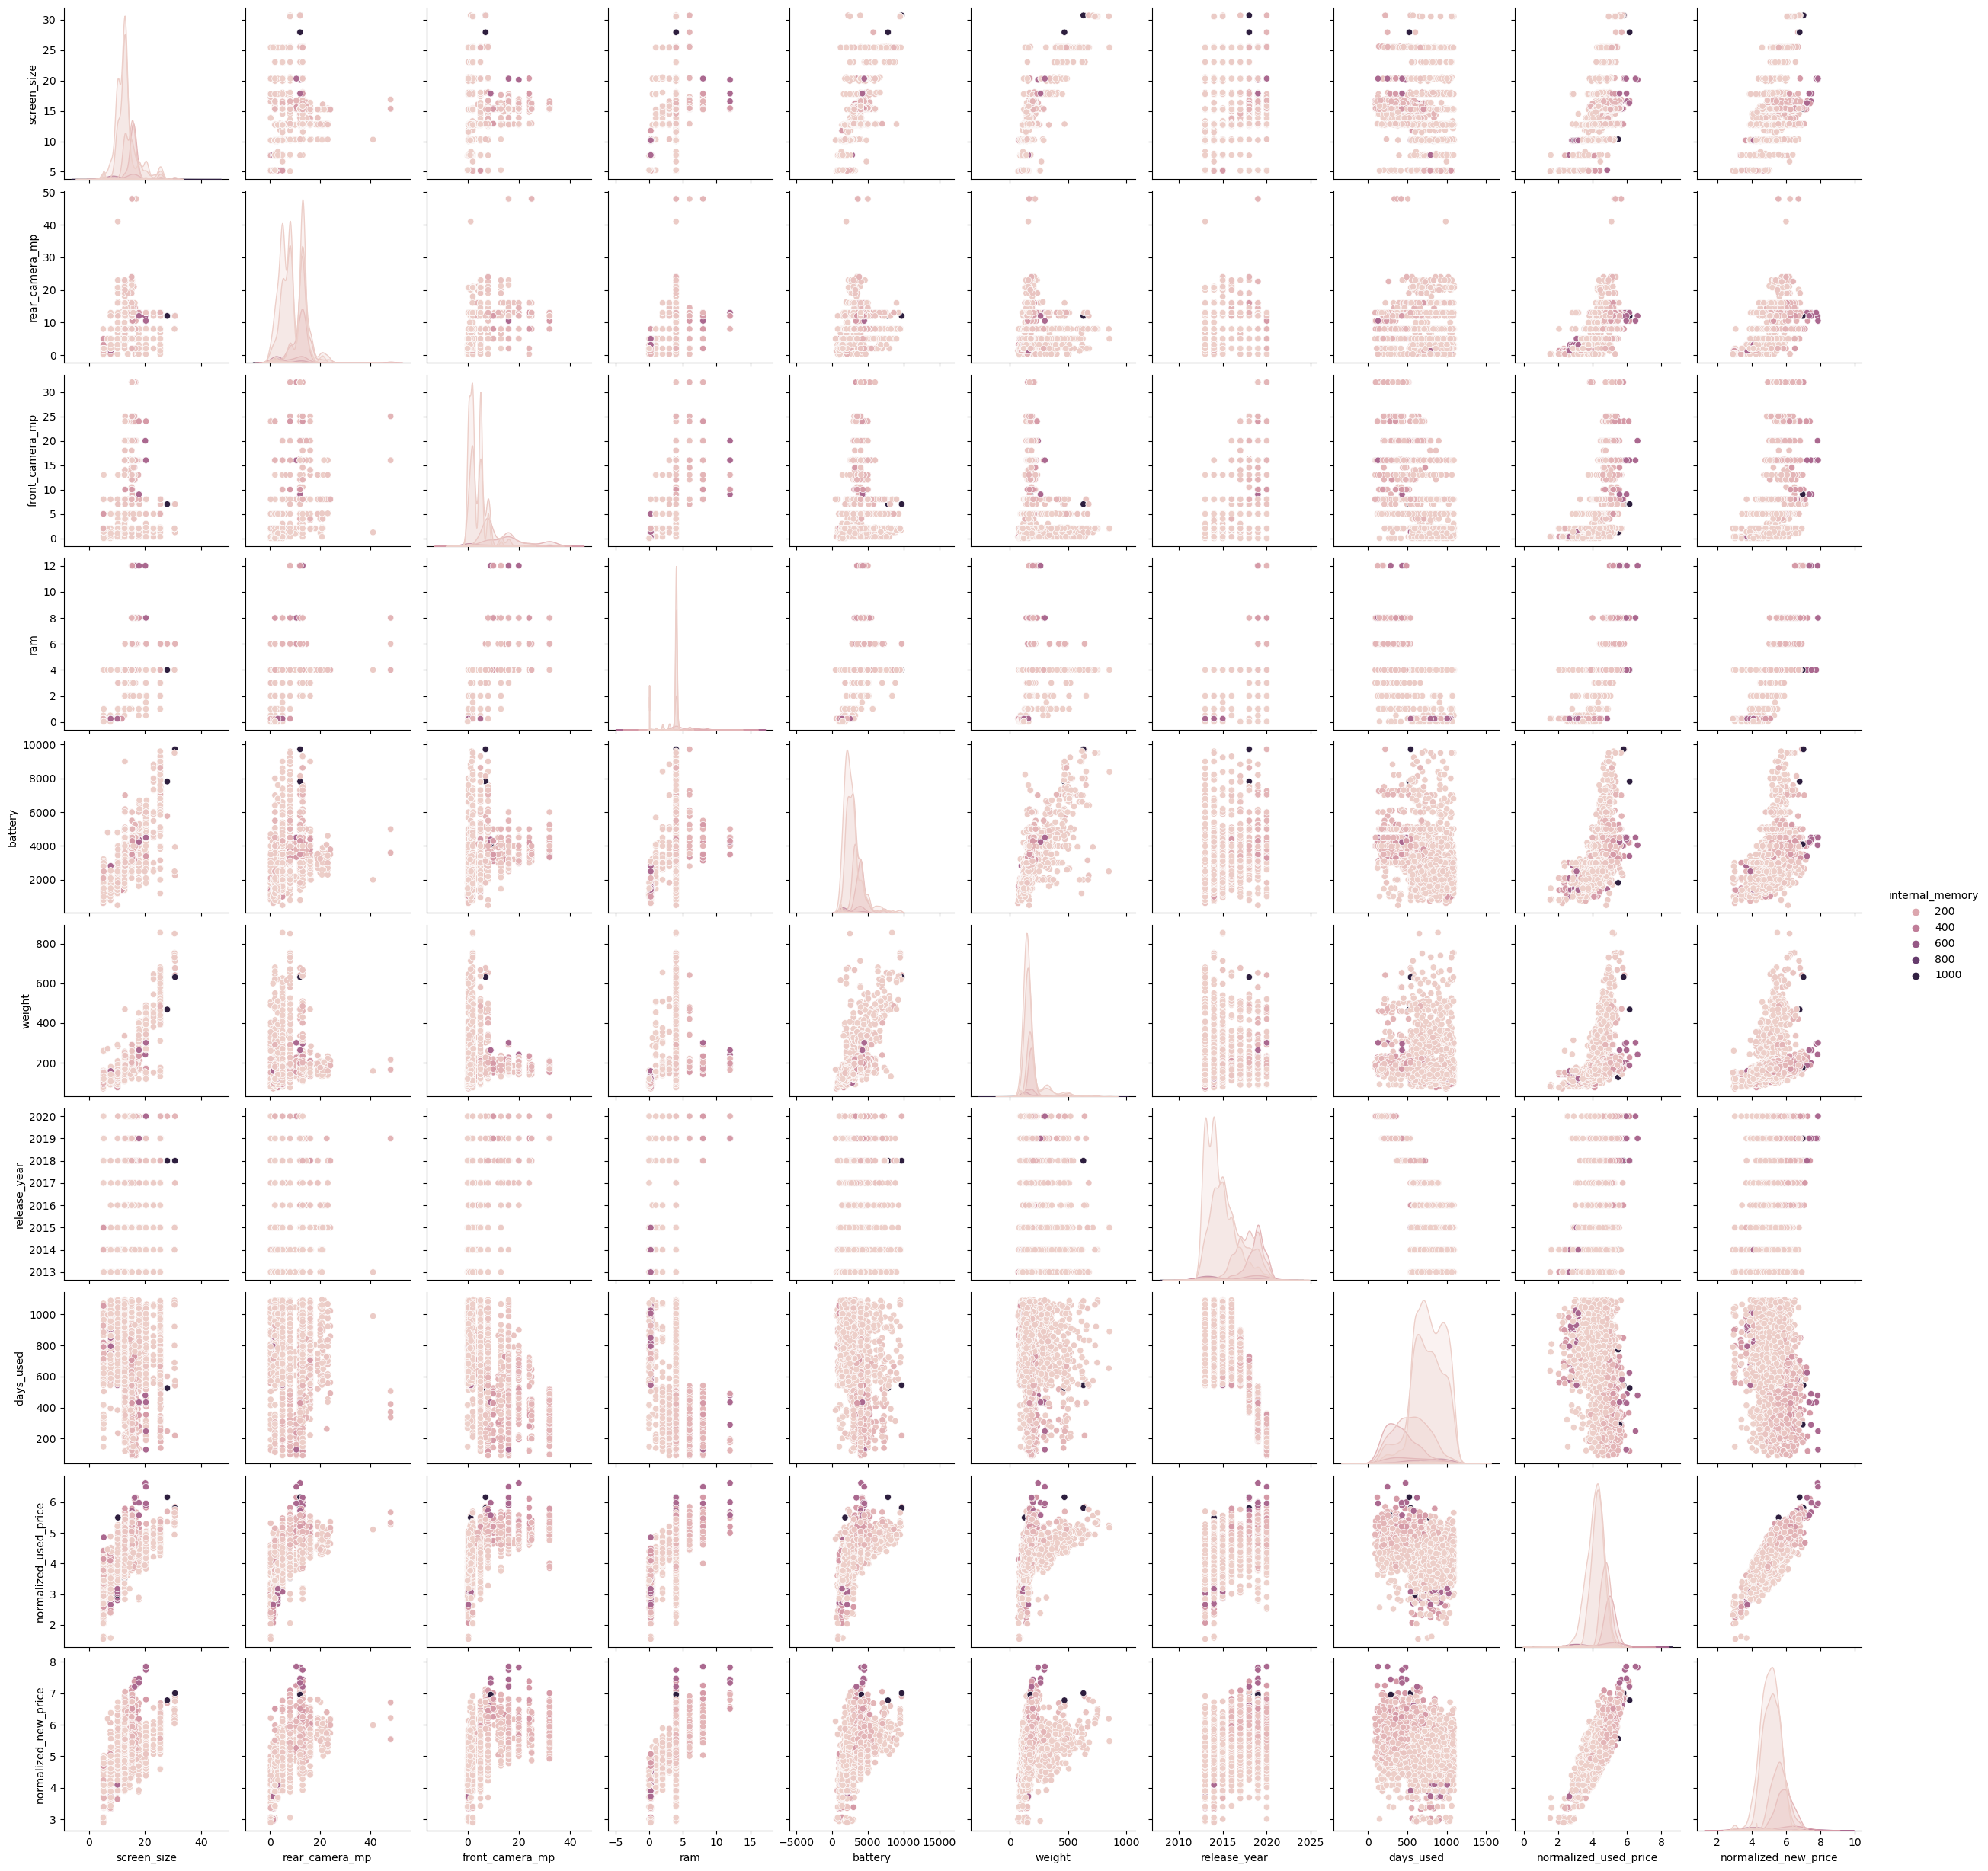

In [24]:
 sb.pairplot(data=pairplotData, hue='internal_memory')

# Model training and evaluation

## Implementing Principle Component Analysis and Mutual Information Regression


In [25]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer/float dtypes (double-check this before using MI!)
X.dtypes 

device_brand              int64
os                        int64
screen_size             float64
4g                        int64
5g                        int64
rear_camera_mp          float64
front_camera_mp         float64
internal_memory         float64
ram                     float64
battery                 float64
weight                  float64
release_year              int64
days_used                 int64
normalized_new_price    float64
dtype: object

In [26]:
from sklearn.feature_selection import mutual_info_regression


mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores  # show a few features with their MI scores

normalized_new_price    0.599335
screen_size             0.484623
battery                 0.413294
front_camera_mp         0.383466
rear_camera_mp          0.369858
internal_memory         0.332485
weight                  0.316130
release_year            0.187231
4g                      0.179701
ram                     0.171749
device_brand            0.133843
os                      0.066731
days_used               0.063984
5g                      0.045183
Name: MI Scores, dtype: float64

### To determine which are the most important variables are, we need to first identify which selection model we should use. When selecting the model, we need to look at the type of data, number of features, complexity of relationships. Looking at the pairplots, we identify that the relationship is non-linear. Since the relationship between the features and the target variable (normalized_used_price) is non-linear and complex, we will use Mutual Information Regression (MIR) to find the rank the variables. We then use kbest to take the top 5 variables from the results of the MIR. Here, we have identified our top 5 variables.

### Since our dataset consisted of many variables, it had a high dimensionality, which would lead to overfitting, increased computational complexity, and feature redundancy. To address this, we used PCA (Principal Component Analysis), which reduces the number of features while preserving the important information. Here, we use PCA reduce the dimensionality of the dataset, improving the accuracy and efficiency of the model.

In [27]:
from sklearn.decomposition import PCA


def PCAx(X):

    # Create a PCA model with the desired number of components
    pca = PCA()

    # Fit the PCA model to the data
    pca.fit(X)

    # Transform the data into the new feature space
    X_pca = pca.transform(X)
    return X_pca

# Selecting the K best features that describe the normalized used price

In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X, val_X, train_full_y, val_y = train_test_split(X, y,test_size=0.2,random_state = 0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X, train_full_y, test_size=0.25,random_state = 0)
    return (train_X, val_X, train_y, val_y)

# Scaling and normalizing data

## Standard Scaler is used when the data is normal, whereas Min Max Scaler is used when we know the minimum and maximum value of the variables from domain knowledge. Looking at the histograms, we find that not all variables follow a normal distribution. Thus, a Min Max Scaler was used.


## Furthermore, the minimum and maximum values of a variable in the used devices are known, as they are recorded within the dataset, as well as in research literature or product information pages. Thus a Min Max Scaler was used.

In [29]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X

In [30]:
scores=[]

### In order to ensure accuracy between all the models we used, we standardized our model training pipeline. We began by selecting the K best scores, before proceeding with PCA. This was done as we wanted to leverage on PCA to further refine the top 5 data selected. This would allow the resultant data to be the best data which captures the relationship between the response and predictors, allowing for a better model.

### We also plotted the actual data against the predicted data to evaluate the accuracy of the models. We also plotted the residual plots to further analyse the models. These visualizations would aid us in understanding the relationships between the predicted and actual values.

# Using top 5 features to do decisionTreeRegression

# Using all features to perform decisionTreeRegression

Decision Tree Regression with top 5 features
R2:  0.6616
MSE:  0.1091


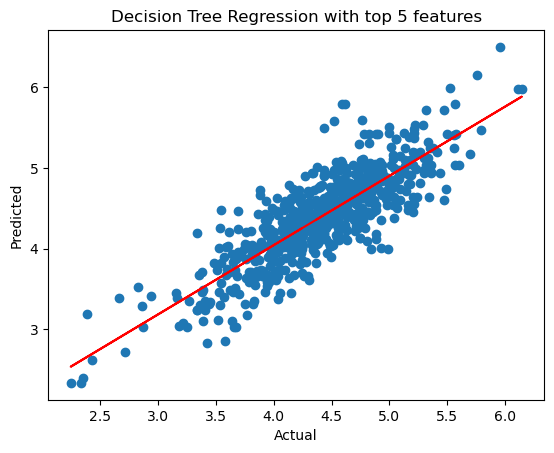

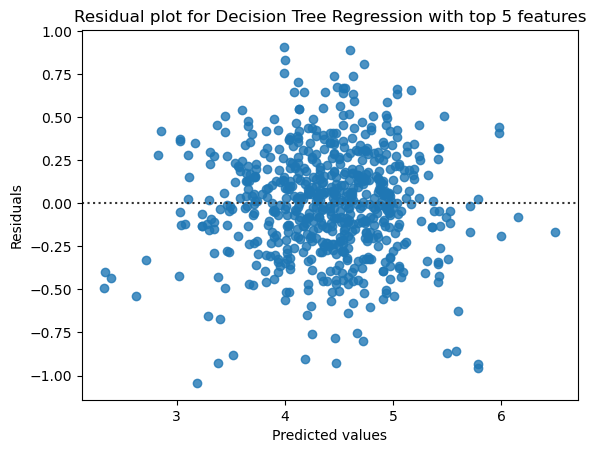

In [31]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)

X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

decision_model= DecisionTreeRegressor(random_state=1)
decision_model.fit(X_train, y_train)
preds= decision_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Decision Tree Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression with top 5 features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = decision_model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Decision Tree Regression with top 5 features')
plt.show()

Decision Tree Regreesion with all features
R2:  0.5966
MSE:  0.13


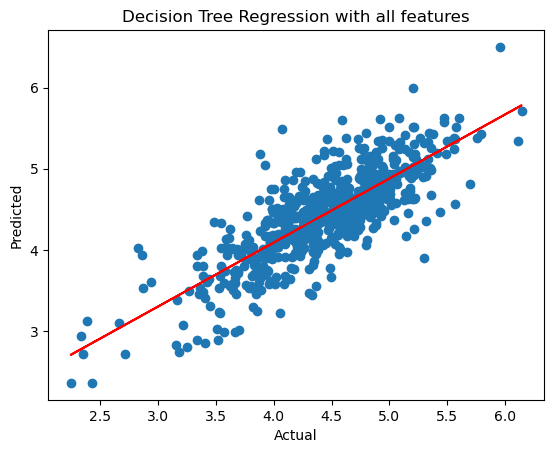

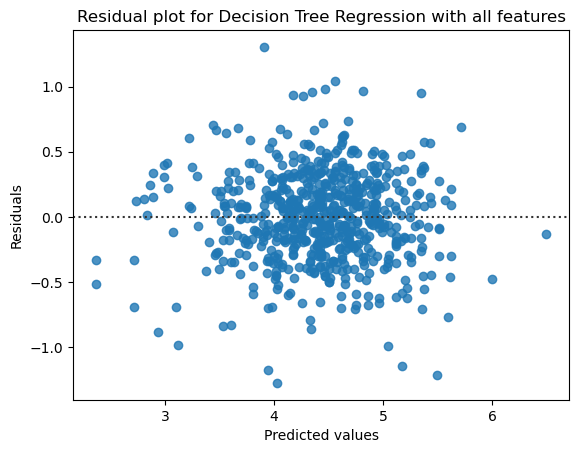

In [32]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)

X_train,X_val,y_train,y_val= dataset(X,y)

decision_model1= DecisionTreeRegressor(random_state=1)
decision_model1.fit(X_train, y_train)
preds= decision_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Decision Tree Regreesion with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Decision Tree Regression with all features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = decision_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Decision Tree Regression with all features')
plt.show()

# Top 5 features using Random Forest Regressor

Random Forest Regression with top 5 features
R2:  0.8045
MSE:  0.063


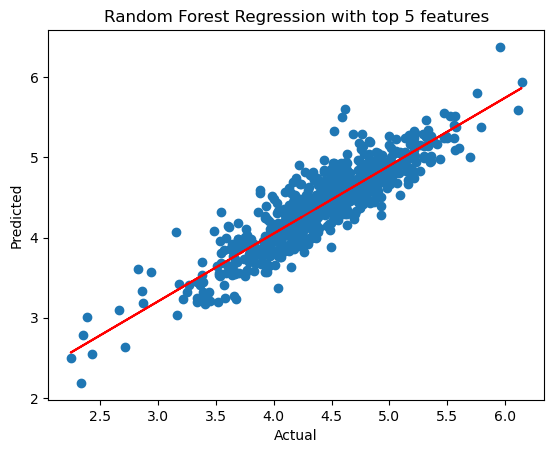

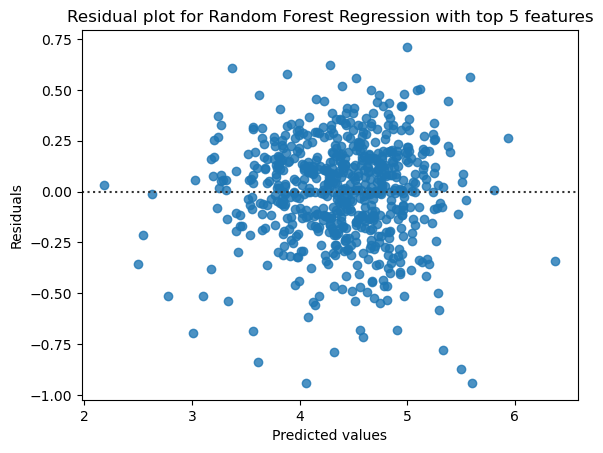

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

random_model= RandomForestRegressor(random_state=1)
random_model.fit(X_train, y_train)
preds= random_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Random Forest Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression with top 5 features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = random_model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Random Forest Regression with top 5 features')
plt.show()


# All features using Random Forest Regressor

Random Forest Regression with all features
R2:  0.7955
MSE:  0.0659


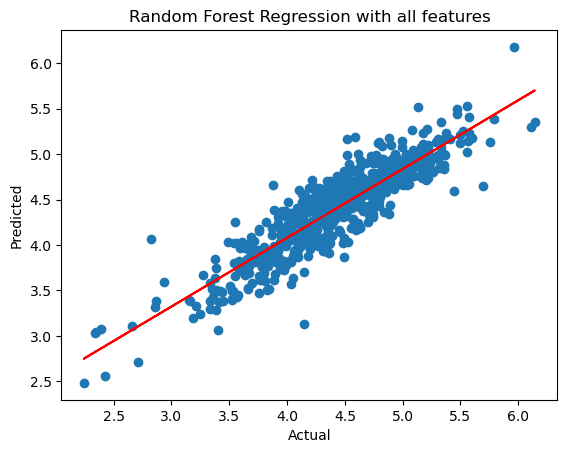

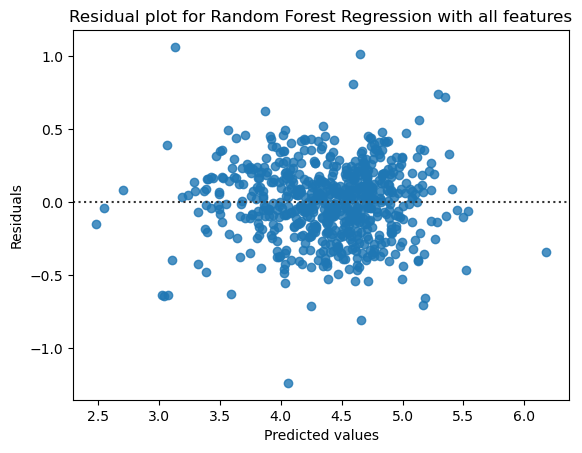

In [34]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

random_model1= RandomForestRegressor(random_state=1)
random_model1.fit(X_train, y_train)
preds= random_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Random Forest Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression with all features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = random_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Random Forest Regression with all features')
plt.show()

In [35]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price
X=pd.get_dummies(X)
colNames = X.columns
# X

# Top 5 features using Linear Regression

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

linear_model= LinearRegression()
linear_model.fit(X_train, y_train)
preds= linear_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Linear Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Linear Regression with top 5 features
R2:  0.8183
MSE:  0.0586


# All features using Linear Regression

In [37]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

linear_model1= LinearRegression()
linear_model1.fit(X_train, y_train)
preds= linear_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Linear Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Linear Regression with all features
R2:  0.8274
MSE:  0.0557


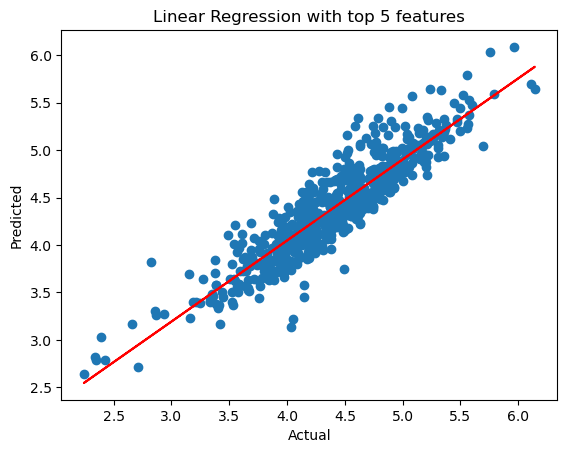

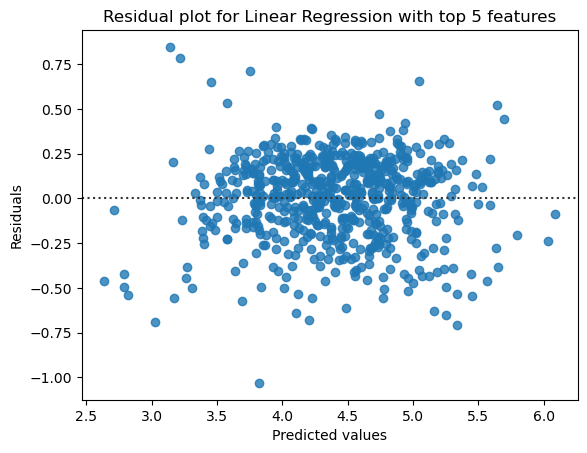

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression with top 5 features")

# Show the plot
plt.show()


import seaborn as sb

# Predict on validation set
y_pred = linear_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Linear Regression with top 5 features')
plt.show()

# Performing Ridge Regression using top 5 features

In [39]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

ridge_model= Ridge(random_state=1)
ridge_model.fit(X_train, y_train)
preds= ridge_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Ridge Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Ridge Regression with top 5 features
R2:  0.8187
MSE:  0.0584


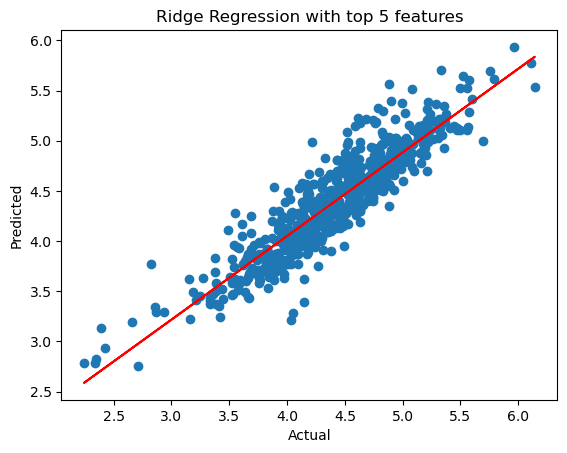

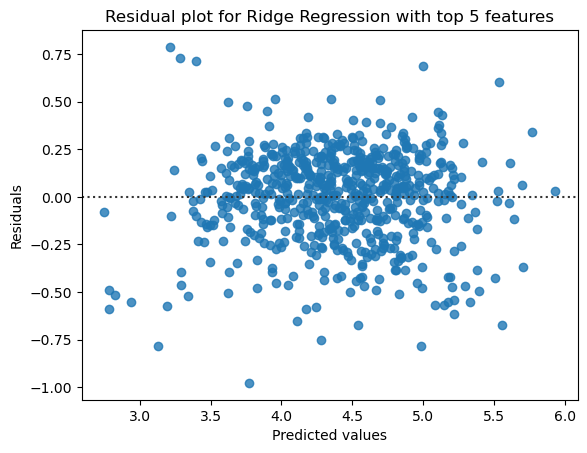

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ridge Regression with top 5 features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = ridge_model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Ridge Regression with top 5 features')
plt.show()

# Performing Ridge Regression using all variables

Ridge Regression with all features
R2:  0.8282
MSE:  0.0554


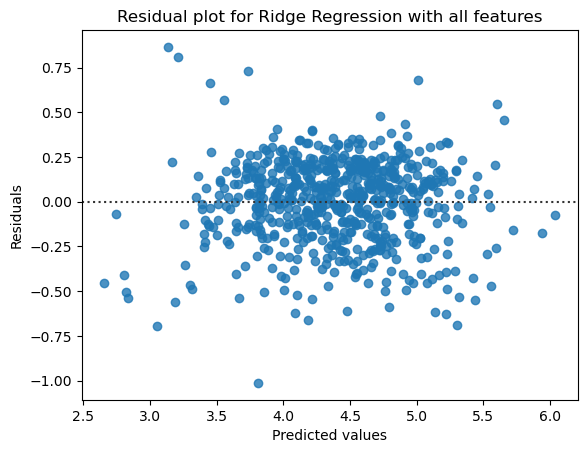

In [41]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

ridge_model1= Ridge(random_state=1)
ridge_model1.fit(X_train, y_train)
preds= ridge_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Ridge Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import seaborn as sb

# Predict on validation set
y_pred = ridge_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Ridge Regression with all features')
plt.show()

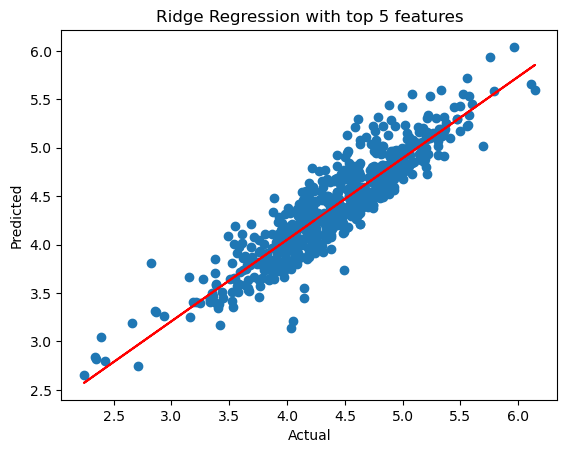

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ridge Regression with top 5 features")

# Show the plot
plt.show()



# Performing Lasso Regression using top 5 variables

In [43]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

lasso_model= Lasso(random_state=1)
lasso_model.fit(X_train, y_train)
preds= lasso_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Lasso Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

Lasso Regression with top 5 features
R2:  -0.02
MSE:  0.3288


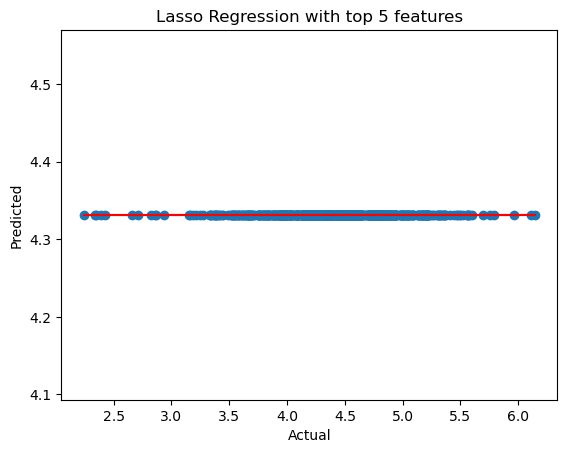

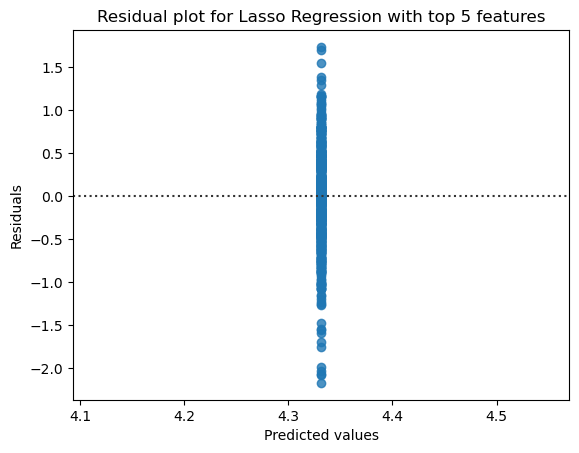

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Lasso Regression with top 5 features")

# Show the plot
plt.show()


import seaborn as sb

# Predict on validation set
y_pred = lasso_model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Lasso Regression with top 5 features')
plt.show()

# Performing Lasso Regression using all variables

Lasso Regression with all features
R2:  -0.02
MSE:  0.3288


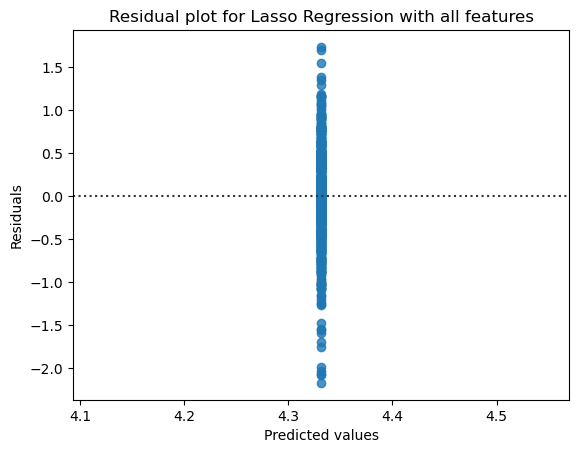

In [45]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

lasso_model1= Lasso(random_state=1)
lasso_model1.fit(X_train, y_train)
preds= lasso_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "Lasso Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import seaborn as sb

# Predict on validation set
y_pred = lasso_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Lasso Regression with all features')
plt.show()

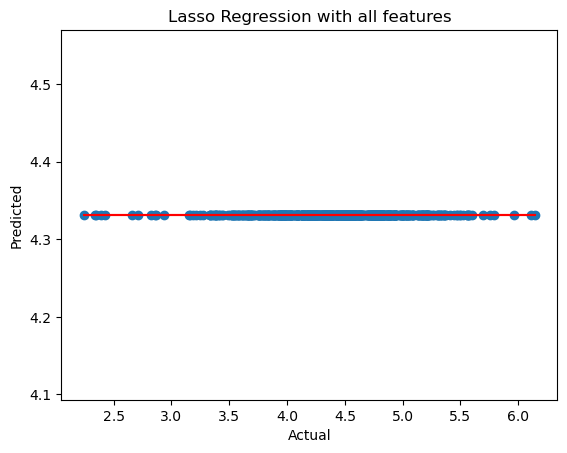

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Lasso Regression with all features")

# Show the plot
plt.show()

# Performing Support Vector Regression using top 5 features

SVM Regression with top 5 features
R2:  0.8197
MSE:  0.0581


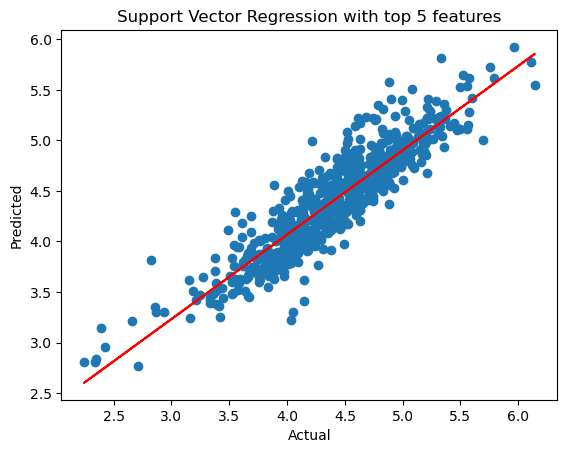

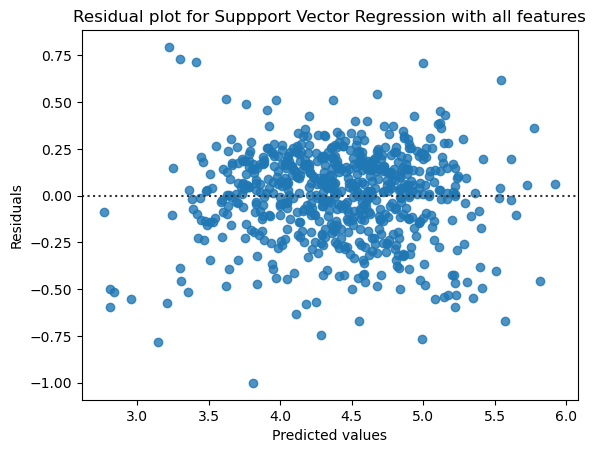

In [47]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)

k = 5 # number of top features to select
top_k_features = SelectKBest(score_func=mutual_info_regression, k=k).fit(X, y)
X_new = top_k_features.transform(X)

X_new= scale(X_new)
X= PCAx(X_new)
X_train,X_val,y_train,y_val= dataset(X,y)

svm_model= SVR(kernel='linear')
svm_model.fit(X_train, y_train)
preds= svm_model.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "SVM Regression with top 5 features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))


import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Support Vector Regression with top 5 features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = svm_model.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Suppport Vector Regression with all features')
plt.show()

# Performing Support Vector Regression using all variables

SVM Regression with all features
R2:  0.8273
MSE:  0.0557


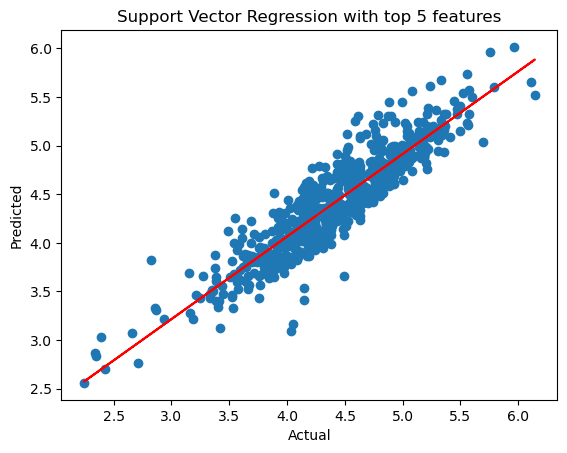

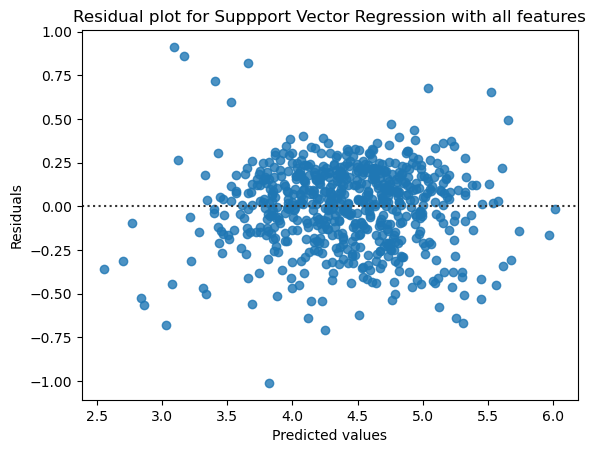

In [48]:
X= data.drop('normalized_used_price',axis=1)
y= data.normalized_used_price

X=pd.get_dummies(X)


X= scale(X)
X= PCAx(X)
X_train,X_val,y_train,y_val= dataset(X,y)

svm_model1= SVR(kernel='linear')
svm_model1.fit(X_train, y_train)
preds= svm_model1.predict(X_val)

r2= r2_score(y_val,preds)
MSE= mean_squared_error(y_val,preds)


a= "SVM Regression with all features"
print(a)
print("R2: ",round(r2,4))
print("MSE: ",round(MSE,4))

scores.append((a,round(r2,4),round(MSE,4)))

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_val and preds are the actual and predicted values, respectively
# Calculate the slope and intercept of the regression line
slope, intercept = np.polyfit(y_val, preds, 1)

# Plot the scatter plot
plt.scatter(y_val, preds)

# Add the regression line to the scatter plot
plt.plot(y_val, slope*y_val + intercept, color='r')

# Add axis labels and title
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Support Vector Regression with all features")

# Show the plot
plt.show()

import seaborn as sb

# Predict on validation set
y_pred = svm_model1.predict(X_val)

# Calculate residuals
residuals = y_val - y_pred

# Create residual plot using Seaborn
sb.residplot(y_pred, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot for Suppport Vector Regression with all features')
plt.show()

In [49]:
columns=['models','R2','MSE']
score= pd.DataFrame(scores, columns=columns)
score

models      R2     MSE
0   Decision Tree Regression with top 5 features  0.6616  0.1091
1     Decision Tree Regreesion with all features  0.5966  0.1300
2   Random Forest Regression with top 5 features  0.8045  0.0630
3     Random Forest Regression with all features  0.7955  0.0659
4          Linear Regression with top 5 features  0.8183  0.0586
5            Linear Regression with all features  0.8274  0.0557
6           Ridge Regression with top 5 features  0.8187  0.0584
7             Ridge Regression with all features  0.8282  0.0554
8           Lasso Regression with top 5 features -0.0200  0.3288
9             Lasso Regression with all features -0.0200  0.3288
10            SVM Regression with top 5 features  0.8197  0.0581
11              SVM Regression with all features  0.8273  0.0557

# Conclusion and Insights

### The regression models displayed good to excellent relationships between predictors and response variables, with the exception of Lasso Regression. This suggests that a simple linear relationship is shared between predictors and response variables. 

### This would provide an intuitive understanding of pricing to sellers and buyers, and also provide a computationally cheap and accurate model to predict used device price. 

### The non-linear relationships between the variables seem to have been nicely processed by our data preparation pipeline, resulting in a simple linear regression giving the most accurate predictions given the dataset. Proper data preparation is thus an important steps, as regression models and other models are dependent on the data supplied. This was a lesson learnt through this mini project as well. 